In [3]:
#import all necessary libaries

from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

import json
from src.lib.ManifestHandler import ManifestHandler

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

ModuleNotFoundError: No module named 'src.lib'

In [ ]:
#define all input files

train_dataset_fp = "./training/train_dataset.csv"
manifest_file = "./manifest.json"

In [ ]:
#define utility objects

manifestHandler = ManifestHandler(manifest_file)

In [ ]:
# column_names = ['gender', 'age', 'asthmatic_level', 'race',
#                 'humidity', 'temperature', 'pm2_5', 'pm10', 
#                 'comfort_level']

column_names = ['humidity', 'temperature', 'pm2_5', 'pm10', 'asthmatic_level',
                'predicted_comfort_level']

feature_names = column_names[:-1]
label_name = column_names[-1]

comfort_level_desc = ['Very Good', 'Ok', 'Uncomfortable', 'Very Uncomfortable', 'Hazardous']

#print(comfort_level_desc)
#print("Features: {}".format(feature_names))
#print("Label: {}".format(label_name))

In [ ]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size, 
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

In [ ]:
features, labels = next(iter(train_dataset))

In [ ]:
#for inspecting data
#the graph should display a relationship for humidity and temperature data
#due to the data being generated by random values, it might not show correlations
#would be better to find actual reading for these features

plt.scatter(features['humidity'],
            features['temperature'],
            c=labels,
            cmap='viridis')

plt.xlabel("humidity")
plt.ylabel("temperature");

In [8]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

In [9]:
train_dataset = train_dataset.map(pack_features_vector)

In [10]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[0.58 0.62 1.37 1.19 0.3 ]
 [0.21 0.96 0.38 3.97 0.  ]
 [0.56 0.66 1.78 2.15 0.3 ]
 [0.97 0.77 1.41 2.23 0.2 ]
 [0.87 0.2  0.67 0.65 0.  ]], shape=(5, 5), dtype=float32)


In [11]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(5,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(5)
])

In [12]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=235, shape=(5, 5), dtype=float32, numpy=
array([[ 0.06241101, -0.1805987 , -0.02467701, -0.04981091, -0.26064456],
       [ 0.05441253, -0.14268643, -0.05365153, -0.05204622, -0.2686181 ],
       [ 0.08372535, -0.24670795, -0.06781948, -0.07709736, -0.35657468],
       [ 0.07460903, -0.21960597, -0.05855893, -0.06814747, -0.31737575],
       [ 0.0259354 , -0.07451578, -0.05111326, -0.0340361 , -0.11051786]],
      dtype=float32)>

In [13]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=241, shape=(5, 5), dtype=float32, numpy=
array([[0.23155439, 0.18159975, 0.21224192, 0.20697393, 0.16763002],
       [0.23032753, 0.18912409, 0.20673512, 0.20706725, 0.166746  ],
       [0.24550252, 0.17642114, 0.21097979, 0.2090314 , 0.15806513],
       [0.24020481, 0.1789805 , 0.21025561, 0.20824921, 0.16230984],
       [0.21530785, 0.19473071, 0.19934165, 0.20277508, 0.1878447 ]],
      dtype=float32)>

In [14]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 3 0 0 0 0 0]
    Labels: [4 4 4 4 0 3 4 4 0 4 4 4 2 4 4 3 4 3 3 4 2 4 1 1 0 4 0 2 1 2 2 4]


In [15]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.7290947437286377


In [16]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [17]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.train.get_or_create_global_step()

In [18]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 1.7290947437286377
Step: 1,         Loss: 1.7198455333709717


In [25]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 301

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step)

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 0.680, Accuracy: 71.572%
Epoch 050: Loss: 0.621, Accuracy: 73.173%
Epoch 100: Loss: 0.589, Accuracy: 74.174%
Epoch 150: Loss: 0.553, Accuracy: 74.775%
Epoch 200: Loss: 0.531, Accuracy: 77.277%
Epoch 250: Loss: 0.494, Accuracy: 77.778%
Epoch 300: Loss: 0.475, Accuracy: 79.479%


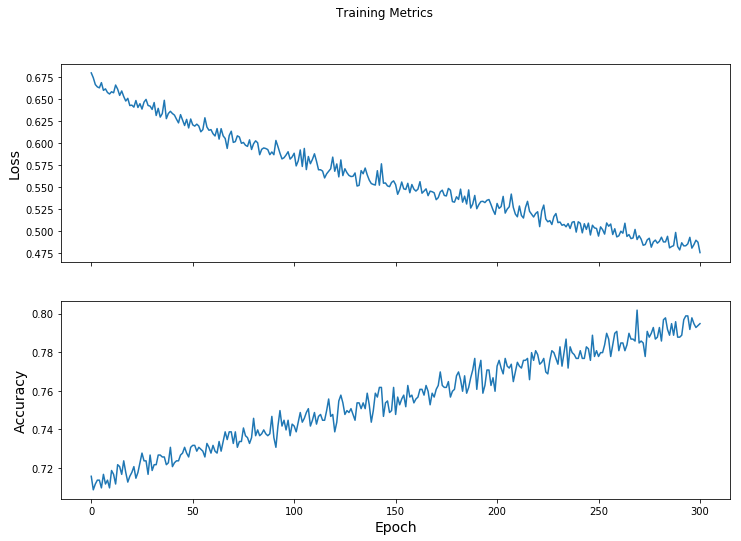

In [26]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results);

In [1]:
test_fp  = "./training/test_dataset.csv"

In [2]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size, 
    column_names=column_names,
    label_name='predicted_comfort_level',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

NameError: name 'tf' is not defined

In [29]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 78.378%


In [30]:
class_names = ['Very Good', 'Ok', 'Uncomfortable', 'Very Uncomfortable', 'Hazardous']

humidity = 0.14
temperature = 0.8
pm2_5 = 1.91
pm10 = 1.09
is_asthmatic = 0.1

logits = [humidity,temperature,pm2_5,pm10,is_asthmatic]
class_idx = tf.argmax(logits).numpy()
p = tf.nn.softmax(logits)[class_idx]
name = class_names[class_idx]
print("class id: " + str(class_idx))
print("Example prediction: {} ({:4.1f}%)".format(name, 100*p))

class id: 2
Example prediction: Uncomfortable (47.5%)
